In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import string
from nltk.corpus import stopwords
from nltk.stem.snowball import EnglishStemmer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, MultiLabelBinarizer
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, coverage_error, label_ranking_average_precision_score, jaccard_score

In [2]:
# load the data associated with programming languages tags
df_prog = pd.read_csv('D:/OP/P5/df_prog.csv')

In [3]:
# load the programming languages tags
df_tags = pd.read_csv('D:/OP/P5/tags_programming_languages.csv')
list_tags = df_tags.Tags.to_list()

In [4]:
stop = stopwords.words('english')
punctuation = string.punctuation

In [5]:
def remove_stopwords_sentence(sentence):
    # print(sentence)
    return pd.Series([word for word in sentence[0].split() if word not in stop])


def remove_stopwords_df(df):
    return df.apply(remove_stopwords_sentence, axis=1)


def stem_sentence(s):
    stemmer = EnglishStemmer()
    return pd.Series([stemmer.stem(w) for w in s if not pd.isna(w)])

In [6]:
body_pipeline = Pipeline(steps=[
    ('remove html tags', FunctionTransformer(pd.DataFrame.replace,
                                             kw_args={'to_replace': '<.*?>', 'value': '', 'regex': True})),
    ('lower', FunctionTransformer(lambda x: x.squeeze(axis=1).str.lower().to_frame())),
    ('remove punctuation', FunctionTransformer(lambda x: x.squeeze(
        axis=1).str.replace('[{}]'.format(punctuation), '').to_frame())),
    ('remove stopwords', FunctionTransformer(remove_stopwords_df, validate=False)),
    ('stemming', FunctionTransformer(pd.DataFrame.apply, kw_args={
     'func': stem_sentence, 'axis': 1}, validate=False)),
    ('imputer', SimpleImputer(strategy='constant', fill_value='')),
    #('vectorizer', CountVectorizer(lowercase=False,analyzer='word', preprocessor=None, tokenizer=lambda i:i ))
])

In [7]:
import re


def check_tag(word, list_tags):
    for t in list_tags:
        if word == t:
            simple_t = re.match('(\.?[a-z]+)', t).group()
            return (True, simple_t)
    return (False, '')


def simplify_tags_sentence(s, list_tags):
    l = []
    for w in s.split(' '):
        b, x = check_tag(w, list_tags)
        if b:
            l.append(x)
    return l

In [8]:
# tags
tags_pipeline = Pipeline(steps=[
    ('remove <>', FunctionTransformer(lambda x: x.str.extractall(
        r'<(.*?)>').groupby(level=0).agg({0: ' '.join}))),
    ('lower', FunctionTransformer(lambda x: x.squeeze(axis=1).str.lower().to_frame())),
    ('select_tags', FunctionTransformer(lambda x: x.squeeze(axis=1).apply(
        simplify_tags_sentence, list_tags=list_tags).to_frame())),
    #('split', FunctionTransformer(lambda x: x.squeeze(axis=1).str.split(expand=True), validate=False)),
    #('imputer', SimpleImputer(strategy='constant',fill_value=''))
])

In [9]:
# apply the pipeline of transformation for the tags
y_prog = tags_pipeline.fit_transform(df_prog.Tags)

In [10]:
# Use MultiLabelBinarizer to encode the tags
mlb = MultiLabelBinarizer()
y2 = mlb.fit_transform(y_prog[0])

In [11]:
# transform the title using the pipeline
title_proc = body_pipeline.fit_transform(df_prog.Title.to_frame())

<ipython-input-5-086abaad0bda>:3: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series([word for word in sentence[0].split() if word not in stop])
<ipython-input-5-086abaad0bda>:12: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  return pd.Series([stemmer.stem(w) for w in s if not pd.isna(w)])


In [12]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(tokenizer=lambda i:i, lowercase=False, stop_words=[''])
X_tfidf = tfidf_vectorizer.fit_transform(title_proc)

In [13]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.multioutput import ClassifierChain
from sklearn.linear_model import LogisticRegression

In [14]:
from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score, cross_validate

In [24]:
from skmultilearn.model_selection import iterative_train_test_split
from collections import Counter
from skmultilearn.model_selection.measures import get_combination_wise_output_matrix

X_train, y_train, X_test, y_test = iterative_train_test_split(X_tfidf, y2, test_size = 0.2)
split = pd.DataFrame({
    'train': Counter(str(combination) for row in get_combination_wise_output_matrix(y_train, order=2) for combination in row),
    'test' : Counter(str(combination) for row in get_combination_wise_output_matrix(y_test, order=2) for combination in row)
}).T.fillna(0.0)

In [23]:
split

,"(2, 2)","(4, 4)","(9, 9)","(14, 14)","(0, 9)","(0, 0)","(39, 39)","(63, 63)","(73, 73)","(58, 58)",...,"(3, 6)","(7, 39)","(14, 73)","(28, 33)","(33, 41)","(0, 66)","(15, 73)","(20, 39)","(20, 73)","(0, 67)"
train,305.0,689.0,6690.0,1010.0,1008.0,1603.0,3674.0,3110.0,330.0,1666.0,...,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0
test,76.0,172.0,1672.0,252.0,252.0,401.0,918.0,777.0,83.0,417.0,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0


In [24]:
X_train

<25313x15054 sparse matrix of type '<class 'numpy.float64'>'
	with 134515 stored elements in Compressed Sparse Row format>

In [25]:
X_tfidf

<31666x15054 sparse matrix of type '<class 'numpy.float64'>'
	with 167650 stored elements in Compressed Sparse Row format>

In [26]:
y_train

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [15]:
from skmultilearn.model_selection import IterativeStratification

def cross_validation_multilabel(model,X,y, n_splits):
    jaccard_train=[]
    jaccard_test = []

    k_fold = IterativeStratification(n_splits=n_splits)
    i=0
    for train, test in k_fold.split(X, y):
        print('start :',i)
        model.fit(X[train], y[train])

        pred_train = model.predict(X[train])
        pred_test = model.predict(X[test])

        jaccard_train.append(jaccard_score(y[train],pred_train,average='samples'))
        jaccard_test.append(jaccard_score(y[test],pred_test,average='samples'))
        print('end :',i)
        i+=1
    return {'jaccard_train':jaccard_train, 'jaccard_test':jaccard_test}

In [35]:
scores_ovr_lr = cross_validation_multilabel(OneVsRestClassifier(LogisticRegression()),X_tfidf,y2,5)

start : 0
end : 0
start : 1
end : 1
start : 2
end : 2
start : 3
end : 3
start : 4
end : 4


In [36]:
scores_ovr_lr

{'jaccard_train': [0.49516158745197114,
  0.4987238155351295,
  0.49316689691467663,
  0.4945155766317592,
  0.4993088163726999],
 'jaccard_test': [0.45165508893800654,
  0.44059416389636435,
  0.46192018111935973,
  0.4521956715401142,
  0.4392350677421055]}

In [38]:
scores_cc_lr = cross_validation_multilabel(ClassifierChain(LogisticRegression(), order='random', random_state=1),X_tfidf,y2,5)

start : 0
end : 0
start : 1
end : 1
start : 2
end : 2
start : 3
end : 3
start : 4
end : 4


In [39]:
scores_cc_lr

{'jaccard_train': [0.5973032348027414,
  0.6012475995054323,
  0.5996359095688749,
  0.5994461546557213,
  0.6002194977259244],
 'jaccard_test': [0.5658131816026553,
  0.5584071262913767,
  0.5628158367692145,
  0.564946797302992,
  0.5643838478817321]}

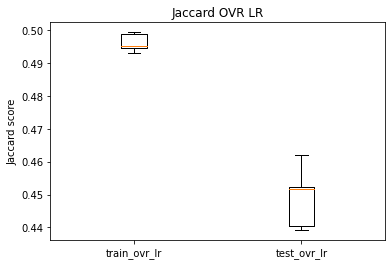

In [41]:
plt.boxplot([scores_ovr_lr.get('jaccard_train'),scores_ovr_lr.get('jaccard_test')],
           labels=['train_ovr_lr','test_ovr_lr'])
plt.title('Jaccard OVR LR')
plt.ylabel('Jaccard score')
plt.show()

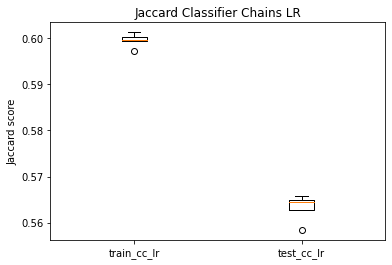

In [42]:
plt.boxplot([scores_cc_lr.get('jaccard_train'),scores_cc_lr.get('jaccard_test')],
           labels=['train_cc_lr','test_cc_lr'])
plt.title('Jaccard Classifier Chains LR')
plt.ylabel('Jaccard score')
plt.show()

In [38]:
from sklearn.svm import SVC

scores_cc_svc = cross_validation_multilabel(ClassifierChain(SVC(kernel='poly'), order='random', random_state=1),X_tfidf,y2,5)

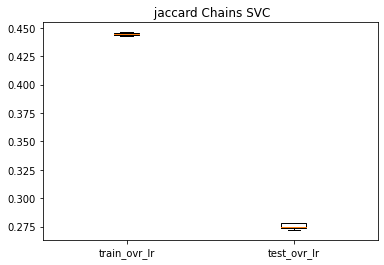

In [43]:
plt.boxplot([scores_cc_svc.get('jaccard_train'),scores_cc_svc.get('jaccard_test')],
           labels=['train_ovr_lr','test_ovr_lr'])
plt.title(' jaccard Chains SVC')
plt.show()

In [51]:
scores_cc_svc

{'jaccard_train': [0.4453360443233711,
  0.4433079713001656,
  0.44301094362454957,
  0.4459703493415346,
  0.4444006860610858],
 'jaccard_test': [0.27204513176581974,
  0.274074074074074,
  0.27785684166139574,
  0.2785136421319797,
  0.2750091131594022]}

In [26]:
from sklearn.ensemble import RandomForestClassifier

In [43]:
scores_cc_rf = cross_validation_multilabel(ClassifierChain(RandomForestClassifier(n_estimators=10,n_jobs=4), order='random', random_state=1),X_tfidf,y2,5)

start : 0
end : 0
start : 1
end : 1
start : 2
end : 2
start : 3
end : 3
start : 4
end : 4


In [44]:
scores_cc_rf

{'jaccard_train': [0.9333603137626512,
  0.931901719514119,
  0.9331015683640815,
  0.9354308300395258,
  0.9336092715231787],
 'jaccard_test': [0.5876952200662564,
  0.5913998943475964,
  0.5959258093289259,
  0.5890407372499737,
  0.5908224833280407]}

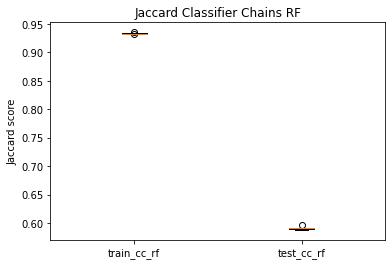

In [46]:
plt.boxplot([scores_cc_rf.get('jaccard_train'),scores_cc_rf.get('jaccard_test')],
           labels=['train_cc_rf','test_cc_rf'])
plt.title('Jaccard Classifier Chains RF')
plt.ylabel('Jaccard score')
plt.show()

In [17]:
scores_cc_rf2 = cross_validation_multilabel(ClassifierChain(RandomForestClassifier(
    min_samples_split=20, n_estimators=100, n_jobs=4), order='random', random_state=1), X_tfidf, y2, 5)

start : 0
end : 0
start : 1
end : 1
start : 2
end : 2
start : 3
end : 3
start : 4
end : 4


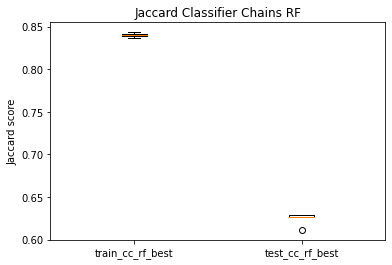

In [47]:
plt.boxplot([scores_cc_rf2.get('jaccard_train'),scores_cc_rf2.get('jaccard_test')],
           labels=['train_cc_rf_best','test_cc_rf_best'])
plt.title('Jaccard Classifier Chains RF')
plt.ylabel('Jaccard score')
plt.show()

In [35]:
# score with min_samples_split = 15
scores_cc_rf2

{'jaccard_train': [0.8625328757035399,
  0.8604919480245646,
  0.8608627838104641,
  0.8595498231635967,
  0.8604002262205387],
 'jaccard_test': [0.6217658541732616,
  0.628858024691358,
  0.6264784734269043,
  0.6268599186863087,
  0.6282162817673731]}

In [19]:
scores_cc_rf2

{'jaccard_train': [0.8372566418214562,
  0.8385073820906923,
  0.8433328073220767,
  0.8398153995947474,
  0.841628482646021],
 'jaccard_test': [0.6290616579489618,
  0.6113234754339049,
  0.6293394534135275,
  0.6264739945251632,
  0.6262257217847769]}

In [29]:
from sklearn.model_selection import GridSearchCV

params_rf = {'base_estimator__max_depth':[500,600,700,800,900], 'base_estimator__min_samples_split':[5,10,15,20]}
grid_rf = GridSearchCV(estimator=ClassifierChain(RandomForestClassifier(n_jobs=4), order='random', random_state=1 ),param_grid=params_rf,
                        scoring='jaccard_samples',cv=4, verbose=1)
grid_rf.fit(X_tfidf, y2)

Fitting 4 folds for each of 20 candidates, totalling 80 fits


KeyboardInterrupt: 

In [30]:
grid_rf.best_estimator_

RandomForestClassifier(max_depth=900, min_samples_split=15, n_jobs=4)

In [31]:
grid_rf.best_score_

0.5262164557886012

In [23]:
import sklearn
sklearn.metrics.SCORERS.keys()

dict_keys(['explained_variance', 'r2', 'max_error', 'neg_median_absolute_error', 'neg_mean_absolute_error', 'neg_mean_absolute_percentage_error', 'neg_mean_squared_error', 'neg_mean_squared_log_error', 'neg_root_mean_squared_error', 'neg_mean_poisson_deviance', 'neg_mean_gamma_deviance', 'accuracy', 'top_k_accuracy', 'roc_auc', 'roc_auc_ovr', 'roc_auc_ovo', 'roc_auc_ovr_weighted', 'roc_auc_ovo_weighted', 'balanced_accuracy', 'average_precision', 'neg_log_loss', 'neg_brier_score', 'adjusted_rand_score', 'rand_score', 'homogeneity_score', 'completeness_score', 'v_measure_score', 'mutual_info_score', 'adjusted_mutual_info_score', 'normalized_mutual_info_score', 'fowlkes_mallows_score', 'precision', 'precision_macro', 'precision_micro', 'precision_samples', 'precision_weighted', 'recall', 'recall_macro', 'recall_micro', 'recall_samples', 'recall_weighted', 'f1', 'f1_macro', 'f1_micro', 'f1_samples', 'f1_weighted', 'jaccard', 'jaccard_macro', 'jaccard_micro', 'jaccard_samples', 'jaccard_wei

In [33]:
scores_rf = cross_validation_multilabel(RandomForestClassifier(min_samples_split=15, n_estimators=10, n_jobs=4), X_tfidf, y2, 5)

start : 0
end : 0
start : 1
end : 1
start : 2
end : 2
start : 3
end : 3
start : 4
end : 4


In [34]:
scores_rf

{'jaccard_train': [0.7910322291617256,
  0.7938507309768688,
  0.7889250322004048,
  0.790399509997629,
  0.7922073904400827],
 'jaccard_test': [0.5374110134003349,
  0.5367175491599088,
  0.5339334813874789,
  0.5351546121593291,
  0.5320593643288679]}

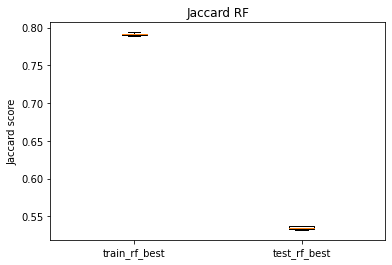

In [48]:
plt.boxplot([scores_rf.get('jaccard_train'),scores_rf.get('jaccard_test')],
           labels=['train_rf_best','test_rf_best'])
plt.title('Jaccard RF')
plt.ylabel('Jaccard score')
plt.show()

### Dummy

In [16]:
from sklearn.dummy import DummyClassifier
scores_dummy = cross_validation_multilabel(DummyClassifier(strategy="most_frequent"), X_tfidf, y2, 5)

start : 0
end : 0
start : 1
end : 1
start : 2
end : 2
start : 3
end : 3
start : 4
end : 4


In [17]:
scores_dummy

{'jaccard_train': [0.0, 0.0, 0.0, 0.0, 0.0],
 'jaccard_test': [0.0, 0.0, 0.0, 0.0, 0.0]}

### DT

In [20]:
scores_dt = cross_validation_multilabel(DecisionTreeClassifier(min_samples_split=15), X_tfidf, y2, 5)

start : 0
end : 0
start : 1
end : 1
start : 2
end : 2
start : 3
end : 3
start : 4
end : 4


In [21]:
scores_dt

{'jaccard_train': [0.8263050227589654,
  0.8323284072249589,
  0.8305228577447727,
  0.8241558971926912,
  0.8290166587715143],
 'jaccard_test': [0.583133164770333,
  0.5725507338525936,
  0.5845301837270341,
  0.588985803342239,
  0.5786154089043258]}

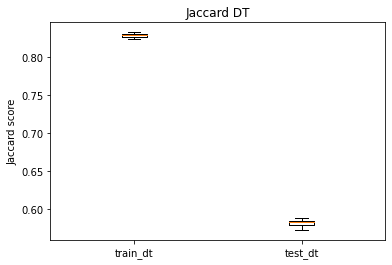

In [23]:
plt.boxplot([scores_dt.get('jaccard_train'),scores_dt.get('jaccard_test')],
           labels=['train_dt','test_dt'])
plt.title('Jaccard DT')
plt.ylabel('Jaccard score')
plt.show()